# Automatic Instance Segmentation with Segment Anything for Microscopy



This notebook shows how to use Segment Anything (SAM) for automatic instance segmentation, using the corresponding functionality from `µsam` (Segment Anything for Microscopy). We use immunoflourescence microscopy images, abbreviated as `Covid IF` (from [Pape et al](https://doi.org/10.1002/bies.202000257)), in this notebook. The functionalities shown here should work for your (microscopy) images too!



We demonstrate using two different functionalities:

1. Automatic Mask Generation (AMG): The "Segment Anything" feature where positive point prompts are sampled in a grid over the entire image to perform instance segmentation.

2. Automatic Instance Segmentation (AIS): A new feature introduced in `µsam` where we train an additional decoder to perform automatic instance segmentation. This method is much faster in AMG and yields better results if it is applied to data that is similar to the finetuning dataset.

## Running this notebook



If you have an environment with `µsam` on your computer you can run this notebook in there. You can follow the [installation instructions](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation) to install it on your computer.



You can also run this notebook in the cloud on [Kaggle Notebooks](https://www.kaggle.com/code/). This service offers free usage of a GPU to speed up running the code. The next cells will take care of the installation for you if you are using it.

In [1]:
# Check if we are running this notebook on kaggle, google colab or local compute resources.



import os

current_spot = os.getcwd()



if current_spot.startswith("/kaggle/working"):

    print("Kaggle says hi!")

    root_dir = "/kaggle/working"



elif current_spot.startswith("/content"):

    print("Google Colab says hi!")

    print(" NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.")

    root_dir = "/content"



    # You might need to install condacolab on Google Colab to be able to install packages using conda / mamba

    # !pip install -q condacolab

    # import condacolab

    # condacolab.install()



else:

    msg = "You are using a behind-the-scenes resource. Follow our installation instructions here:"

    msg += " https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation"

    print(msg)

    root_dir = ""  # overwrite to set the root directory, where the data, checkpoints, and all relevant stuff will be stored

Kaggle says hi!


### Installation



The next cells will install the `micro_sam` library on Kaggle Notebooks. **Please skip these cells and go to `Importing the libraries` if you are running the notebook on your own computer.**

In [2]:
!git clone --quiet https://github.com/computational-cell-analytics/micro-sam.git

tmp_dir = os.path.join(root_dir, "micro-sam")

!pip install --quiet $tmp_dir

In [3]:
!git clone --quiet https://github.com/constantinpape/torch-em.git

tmp_dir = os.path.join(root_dir, "torch-em")

!pip install --quiet $tmp_dir

In [4]:
!git clone --quiet https://github.com/constantinpape/elf.git

tmp_dir = os.path.join(root_dir, "elf")

!pip install --quiet $tmp_dir

Known Issues on **Kaggle Notebooks**:



1. `warning  libmamba Cache file "/opt/conda/pkgs/cache/2ce54b42.json" was modified by another program` (multiples lines of such warnings)

    - We have received this warning while testing this notebook on Kaggle. It does not lead to any issues while making use of the installed packages. You can proceed and ignore the warnings.

In [5]:
!mamba install -q -y -c conda-forge nifty affogato zarr z5py

!pip uninstall -y --quiet qtpy  # qtpy is not supported in Kaggle / Google Colab, let's remove it to avoid errors.

warning  libmamba Cache file "/opt/conda/pkgs/cache/497deca9.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/09cdf8bf.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c6f2354e.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/86b0f08d.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c9ddbd6b.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/b121c3e7.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/d4808d92.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/223a346e.json" was modified by another program
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


## Importing the libraries



(continued) Known Issues on **Kaggle Notebooks**:



2. ```bash

2024-05-08 14:56:42.941557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-05-08 14:56:42.941680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-05-08 14:56:43.062385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

```

    - We have received this warning while testing this notebook on Kaggle. We suspect that the complains originate from the tensorflow suite. It does not lead to any issues while making use of the installed packages. You can proceed and ignore the warnings.

In [8]:
!pip install natsort

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [14]:
import os

from glob import glob



import h5py

import matplotlib.pyplot as plt

from skimage.measure import label as connected_components



from torch_em.util.util import get_random_colors

import torch_em.data.datasets.light_microscopy.covid_if as covid_if


from micro_sam import util

from micro_sam.evaluation.model_comparison import _enhance_image

from micro_sam.instance_segmentation import (

    InstanceSegmentationWithDecoder,

    AutomaticMaskGenerator,

    get_predictor_and_decoder,

    mask_data_to_segmentation

)

## Let's download the dataset



Download the example data from Zenodo.

In [16]:
data_dir = os.path.join(root_dir, "data", "covid_if")

covid_if.get_covid_if_data(path=data_dir, download=True)

print(f"Your data is stored at: {data_dir}")

Download https://zenodo.org/record/5092850/files/covid-if-groundtruth.zip?download=1 to /kaggle/working/data/covid_if/covid-if.zip: 100%|██████████| 491M/491M [02:52<00:00, 2.99MB/s]  


Download successful and checksums agree.
Your data is stored at: /kaggle/working/data/covid_if


## Let's visualize how our samples look



We check out the example data visually with matplotlib and visualize the images and the ground-truth segmentations.

In [17]:
# Convenience function to plot images side-by-side

def plot_samples(image, gt, segmentation=None):

    n_images = 2 if segmentation is None else 3

    fig, ax = plt.subplots(1, n_images, figsize=(10, 10))

    

    ax[0].imshow(_enhance_image(image, do_norm=True), cmap="gray")

    ax[0].axis("off")

    ax[0].set_title("Image")

    

    gt = connected_components(gt)

    ax[1].imshow(gt, cmap=get_random_colors(gt), interpolation="nearest")

    ax[1].axis("off")

    ax[1].set_title("Ground Truth")

    

    if n_images == 3:

        ax[2].imshow(segmentation, cmap=get_random_colors(segmentation), interpolation="nearest")

        ax[2].axis("off")

        ax[2].set_title("Prediction")

        

    plt.show()

    plt.close()

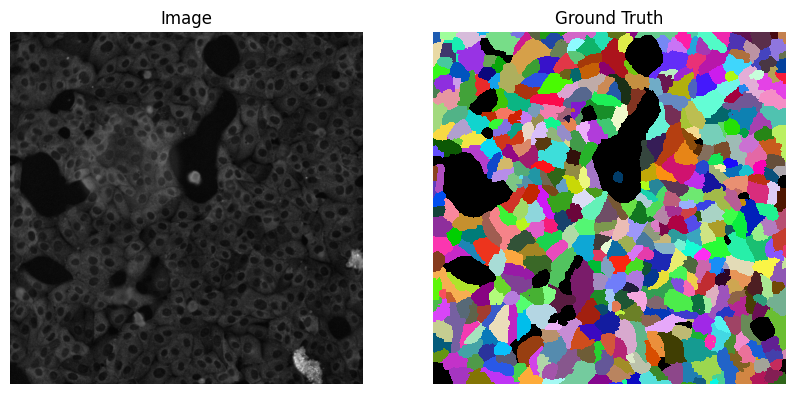

In [18]:
sample_paths = sorted(glob(os.path.join(data_dir, "*")))



for sample_path in sample_paths:

    with h5py.File(sample_path, "r") as f:

        raw = f["raw/serum_IgG/s0"][:]

        labels = f["labels/cells/s0"][:]



    plot_samples(image=raw, gt=labels)



    break  # comment this out in case you want to visualize all images

### Next, we create convenience functions for automatic segmentation methods

In [19]:
def run_automatic_instance_segmentation(image, model_type="vit_b_lm"):

    """Automatic Instance Segmentation by training an additional instance decoder in SAM.



    NOTE: It is supported only for `µsam` models.

    

    Args:

        image: The input image.

        model_type: The choice of the `µsam` model.

        

    Returns:

        The instance segmentation.

    """

    # Step 1: Initialize the model attributes using the pretrained µsam model weights.

    #   - the 'predictor' object for generating predictions using the Segment Anything model.

    #   - the 'decoder' backbone (for AIS).

    predictor, decoder = get_predictor_and_decoder(

        model_type=model_type,  # choice of the Segment Anything model

        checkpoint_path=None,  # overwrite to pass our own finetuned model

    )

    

    # Step 2: Computation of the image embeddings from the vision transformer-based image encoder.

    image_embeddings = util.precompute_image_embeddings(

        predictor=predictor,  # the predictor object responsible for generating predictions

        input_=image,  # the input image

        ndim=2,  # number of input dimensions

    )

    

    # Step 3: Combining the decoder with the Segment Anything backbone for automatic instance segmentation.

    ais = InstanceSegmentationWithDecoder(predictor, decoder)

    

    # Step 4: Initializing the precomputed image embeddings to perform faster automatic instance segmentation.

    ais.initialize(

        image=image,  # the input image

        image_embeddings=image_embeddings,  # precomputed image embeddings

    )



    # Step 5: Getting automatic instance segmentations for the given image and applying the relevant post-processing steps.

    prediction = ais.generate()

    prediction = mask_data_to_segmentation(prediction, with_background=True)

    

    return prediction





def run_automatic_mask_generation(image, model_type="vit_b"):

    """Automatic Mask Generation.

    

    NOTE: It is supported for both Segment Anything models and µsam models.

    

    Args:

        image: The input image.

        model_type: The choice of the `SAM` / `µsam` model.

        

    Returns:

        The instance segmentation.

    """

    # Step 1: Initialize the model attributes using the pretrained SAM / µsam model weights.

    #   - the 'predictor' object for generating predictions using the Segment Anything model.

    predictor = util.get_sam_model(

        model_type=model_type,  # choice of the Segment Anything model

    )

    

    # Step 2: Computation of the image embeddings from the vision transformer-based image encoder.

    image_embeddings = util.precompute_image_embeddings(

        predictor=predictor,  # the predictor object responsible for generating predictions

        input_=image,  # the input image

        ndim=2,  # number of input dimensions

    )

    

    # Step 3: Initializing the predictor for automatic mask generation.

    amg = AutomaticMaskGenerator(predictor)

    

    # Step 4: Initializing the precomputed image embeddings to perform automatic segmentation using automatic mask generation.

    amg.initialize(

        image=image,  # the input image

        image_embeddings=image_embeddings,  # precomputed image embeddings

    )

    

    # Step 5: Getting automatic instance segmentations for the given image and applying the relevant post-processing steps.

    #  - the parameters for `pred_iou_thresh` and `stability_score_thresh` are lowered (w.r.t the defaults) to observe the AMG outputs for the microscopy domain.

    prediction = amg.generate(

        pred_iou_thresh=0.75,

        stability_score_thresh=0.75

    )

    prediction = mask_data_to_segmentation(prediction, with_background=True)

    

    return prediction

### Let's run the default Segment Anything models



We test the smallest default SAM model on the microscopy data, ViT Base (abbreviated as `vit_b`).

100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 413GB/s]
Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


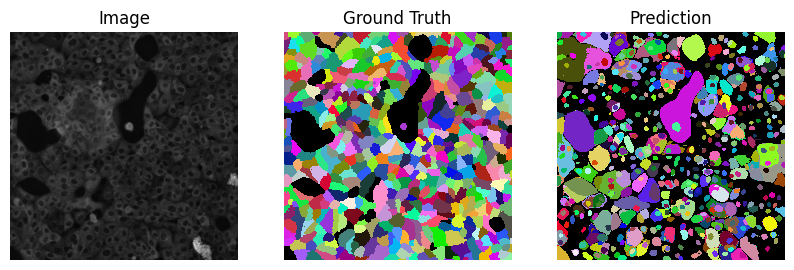

In [20]:
model_choice = "vit_b"



for sample_path in sample_paths:

    with h5py.File(sample_path, "r") as f:

        raw = f["raw/serum_IgG/s0"][:]

        labels = f["labels/cells/s0"][:]

    

    prediction = run_automatic_mask_generation(raw, model_type=model_choice)

    plot_samples(image=raw, gt=labels, segmentation=prediction)

    

    break  # comment this out in case you want to visualize all images

As we see above, Segment Anything does not generalize well for segmenting cells in the above image.



To address this problem, we introduce "Segment Anything for Microscopy". Let's try how AMG works for the finetuned light microscopy generalist model.

100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 431GB/s]
100%|█████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 57.6GB/s]
Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


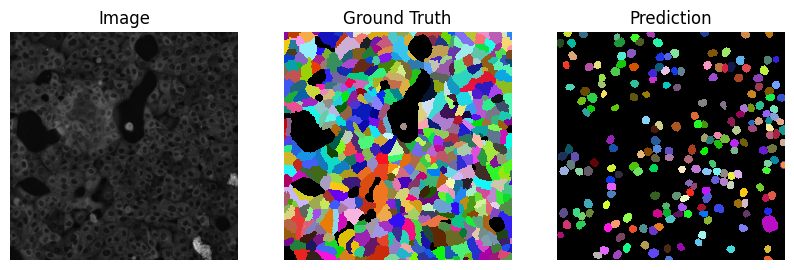

In [21]:
# For consistency, we choose the same configuration of model finetuned on the light microscopy domain.

model_choice = "vit_b_lm"



for sample_path in sample_paths:

    with h5py.File(sample_path, "r") as f:

        raw = f["raw/serum_IgG/s0"][:]

        labels = f["labels/cells/s0"][:]

    

    prediction = run_automatic_mask_generation(raw, model_type=model_choice)

    plot_samples(image=raw, gt=labels, segmentation=prediction)

    

    break  # comment this out in case you want to visualize all images

The segmentation quality is a bit better, but does it achieve our desired results?



To address this problem, `µsam` introduces an additional decoder to improve the segmentation quality by learning the objects with a better heuristic.

Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


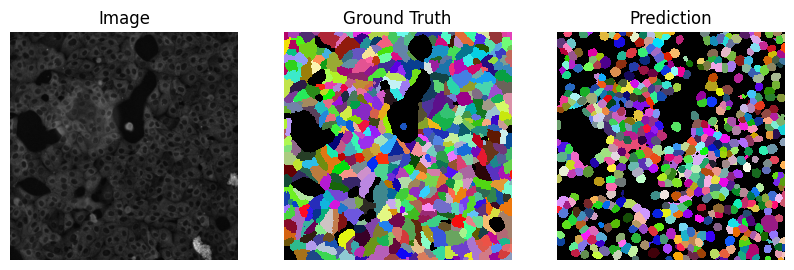

In [22]:
# For consistency, we choose the same configuration of model finetuned on the light microscopy domain.

model_choice = "vit_b_lm"



for sample_path in sample_paths:

    with h5py.File(sample_path, "r") as f:

        raw = f["raw/serum_IgG/s0"][:]

        labels = f["labels/cells/s0"][:]

    

    prediction = run_automatic_instance_segmentation(raw, model_type=model_choice)

    plot_samples(image=raw, gt=labels, segmentation=prediction)

    

    break  # comment this out in case you want to visualize all images

## What next?



Question: Are you happy with the segmentations?



1. If your answer is "YES", looks like you are good to go with your segmentations. Feel free to test it on your custom data.

2. If you think there are missed out objects / incorrect segmentations, and there's room for improvement:

    1. We recommend you to use our napari-based [annotation tool](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#annotation-tools) to improve your segmentations.

    2. If you want to improve the automatic segmentation quality, we recommend you to finetune the default SAM models OR the `µsam` models, based on your initial assessment of the segmentation quality of both models.

3. If you think the models perform poorly, we recommend you to finetune the default SAM models on your custom dataset. There are two situations here:

    1. In case you do not have any ground-truth labels, we recommend generating the desired labels using our [annotator tool](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#annotation-tools)

    2. In case you do have ground-truth labels, we suggest going ahead with finetuning already (you can choose to use the [python scripts](https://github.com/computational-cell-analytics/micro-sam/blob/master/examples/finetuning/finetune_hela.py) or the [tool](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#finetuning-ui) for this.)

    

[Here](https://github.com/computational-cell-analytics/micro-sam/blob/master/notebooks/sam_finetuning.ipynb) is the link to the notebook on how to get quickly started with finetuning on your custom dataset.

*This notebook was last ran on nov 13, 2024*